# RFMS clustering using DBSCAN

DBSCSAN stands for "Density-Based Spatial Clustering of Applications with Noise", it's proved efficient when your data may have outliers
or with skewed datasets.

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

rfms = pd.read_csv("./../../../output/rms.csv")
y = rfms['review_score']

X_train, X_test, y_train, y_test = train_test_split(rfms, y, test_size=0.2, random_state=42, stratify=y)
rfms = X_test

rfms

recency  frequency  monetary  nb_orders  review_score  \
4346     425.0        1.0    116.36        1.0           5.0   
37624    117.0        1.0    115.48        1.0           5.0   
34075    143.0        1.0    594.42        1.0           5.0   
89326    322.0        1.0     83.94        1.0           5.0   
79142    278.0        1.0     52.78        1.0           5.0   
...        ...        ...       ...        ...           ...   
18638    139.0        1.0     72.28        1.0           4.0   
50936     42.0        1.0    122.97        1.0           4.0   
38477    402.0        1.0    135.12        1.0           5.0   
90762     42.0        1.0    219.44        1.0           0.0   
44912    273.0        1.0     84.49        1.0           5.0   

       review_completion_percentage  
4346                      33.333333  
37624                    100.000000  
34075                     66.666667  
89326                     33.333333  
79142                     33.333333  
...                             ...  
18638                     33.333333  
50936                     33.333333  
38477                     66.666667  
90762                      0.000000  
44912                     33.333333  

[18622 rows x 6 columns]

It's not required by DBSCAN to have variables with normal distributions, but it never hurt to scale our variables:

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customers_vars = rfms[["recency", "frequency", "monetary", "review_score"]]
scaler.fit(customers_vars)

scaled_customers = scaler.transform(customers_vars)

scaled_customers

array([[ 1.21399954, -0.03280069, -0.22333186,  0.66226064],
       [-0.79757495, -0.03280069, -0.22758092,  0.66226064],
       [-0.62776671, -0.03280069,  2.08496986,  0.66226064],
       ...,
       [ 1.06378456, -0.03280069, -0.13274963,  0.66226064],
       [-1.28740639, -0.03280069,  0.27438755, -3.12695001],
       [ 0.22127447, -0.03280069, -0.37721542,  0.66226064]])

We need to determine the optimal value for epsilon (eps) and the number of samples (min_samples).
Two points are considered neighbors if the distance between the two points is below the threshold epsilon.

As stated by most of data scientists, you may chose the number of samples according to your business.
If you have no idea about the number of clusters for this kind of business, you can apply the [following formula](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf):

min_samples = 2 * (number of variables)

In our case, we have 4 variables so we select **8** as `min_samples` value.

Then we will estimate an optimal value for epsilon.

In [4]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=8).fit(scaled_customers)
distances, idx = nearest_neighbors.kneighbors(scaled_customers)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
fig = px.line(None, y=distances, title="Evaluation of epsilon")
fig.show()

It look likes a value of eps around [0.3-1.8] is optimal.

eps  n_clusters  noise_points  silhouette_score
0   0.5          13           510          0.238172
1   0.6           7           375          0.336644
2   0.7           7           283          0.351103
3   0.8           6           179          0.375879
4   0.9           5           109          0.382095
5   1.0           5            79          0.387667
6   1.1           5            55          0.385794
7   1.2           5            38          0.385237
8   1.3           3            36          0.613832
9   1.4           3            32          0.613932
10  1.5           3            28          0.613714
11  1.6           3            22          0.614779
12  1.7           3            16          0.614327
13  1.8           3            13          0.615667
14  1.9           3            13          0.615667

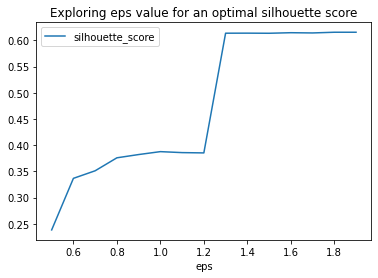

In [5]:
from sklearn import metrics
import numpy as np

# Compute DBSCAN
report = []
for eps_value in np.arange(0.5, 2, 0.1):
    dbscan = DBSCAN(eps=eps_value, min_samples=8, n_jobs=-1).fit(scaled_customers)
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score = metrics.silhouette_score(scaled_customers, labels)
    report.append({
        'eps': eps_value,
        'n_clusters': n_clusters_,
        'noise_points': n_noise_,
        'silhouette_score': score
    })

df_report = pd.DataFrame(report)
df_report.plot(title="Exploring eps value for an optimal silhouette score", x='eps', y='silhouette_score')

df_report.head(15)

An optimal eps value is : **1.5** for **3** clusters

In [6]:
# Compute DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=8).fit(scaled_customers)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(
    "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(scaled_customers, labels)
)

Estimated number of clusters: 3
Estimated number of noise points: 28
Silhouette Coefficient: 0.614


In [7]:
rfms["cluster"] = labels
rfms.cluster = rfms.cluster.astype("category")

#### Clustering visualisation

In [8]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)
projected_customers = tsne.fit_transform(scaled_customers)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=rfms.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [9]:
# cluster for value equals to -1 is noise
rfm = rfms[rfms.cluster != -1]
fig = px.scatter_3d(rfm, x="recency", y="monetary", z="frequency", color="cluster")
fig.show()

### Conclusions on DBSCAN

Sadly, as we can see the frequency have the biggest impact and there is nothing more we can learn from this clustering if we use only RFM metrics.
If we want a better clustering, we must integrate more data.